In [2]:
import json
import requests
import pandas as pd
import numpy as np
import networkx as nx
import nxpd
import matplotlib.pyplot as plt
import matplotlib
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import dataframe
import graphframes


from src.data_reader import DataReader, RetractionFinder
from src.to_gexf import to_gexf
from src.get_redacted import get_paper, load_redacted, get_doi, gen_retracted
import src.load_data as load_data

In [144]:
df_full = load_data.load_dataframe(source='data/retracted_articles', limit=-1)
df = load_data.format_dataframe(df_full)

# EDA

In [59]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_curve

In [42]:
X,y = df.loc[:, ['numInCitations','numAuthors', 'numEntities', 'year', 'pageLength']], df['retracted']

for col in X.columns:
    X[col] = X[col].fillna(value=int(X[col].mean()))
    
X0,Xt,y0,yt = train_test_split(X,y)

In [56]:
rf = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=1000)
rf.fit(X0, y0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
log_loss(y_pred=rf.predict_proba(Xt)[:,1], y_true=yt)

0.31474815683211166

<BarContainer object of 5 artists>

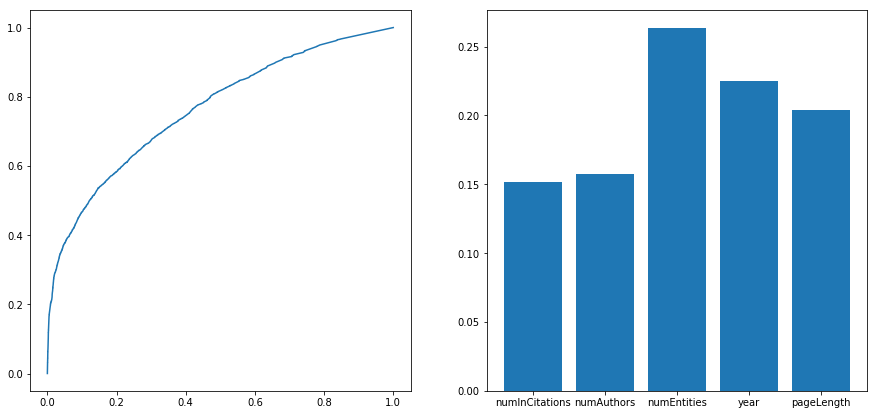

In [83]:
fpr, tpr, thr = roc_curve(y_score=rf.predict_proba(Xt)[:,1], y_true=yt)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))
ax0.plot(fpr, tpr)
ax1.bar(x=X.columns, height=rf.feature_importances_)

In [131]:
def plot_proportions(X, y, lbl):
    xx, yy = [], []
    for val in np.unique(X[lbl]):
        xx.append(val)
        y_hat = y[X[lbl] == val]
        yy.append(y_hat.sum()/len(y_hat))
    return xx,yy

(0, 20)

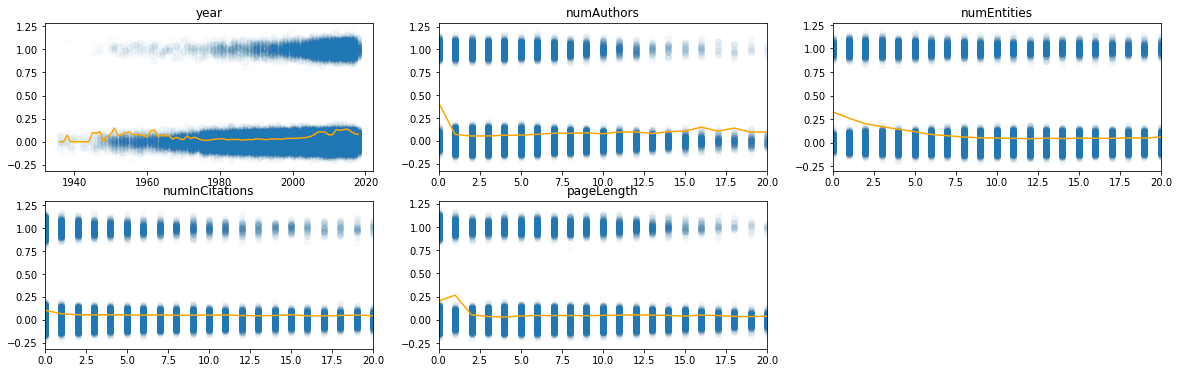

In [141]:
plt.subplots(figsize=(20,6))
plt.subplot('231')
plt.scatter(X['year'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'year'), c='orange')
plt.title('year')

plt.subplot('232')
plt.scatter(X['numAuthors'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'numAuthors'), c='orange')
plt.xlim(0,20)
plt.title('numAuthors')

plt.subplot('233')
plt.scatter(X['numEntities'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'numEntities'), c='orange')
plt.xlim(0,20)
plt.title('numEntities')

plt.subplot('234')
plt.scatter(X['numInCitations'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'numInCitations'), c='orange')
plt.xlim(0,20)
plt.title('numInCitations')

plt.subplot('235')
plt.scatter(X['pageLength'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'pageLength'), c='orange')
plt.title('pageLength')
plt.xlim(0,20)


In [153]:
has_p_value = df_full['paperAbstract'].apply(lambda x: any(p in x.lower() for p in ('pvalue','p-value', 'p value')))

In [173]:
print(len(df_full['paperAbstract'][has_p_value & df['retracted']]), sum(df['retracted']))
print(len(df_full['paperAbstract'][has_p_value & df['retracted']])/sum(df['retracted']))
print(np.std([has_p_value & df['retracted']]))

37 13401
0.002760987985971196
0.014151585635026229


In [174]:
print(len(df_full['paperAbstract'][has_p_value & ~df['retracted']]), sum(~df['retracted']))
print(len(df_full['paperAbstract'][has_p_value & ~df['retracted']])/sum(~df['retracted']))
print(np.std([has_p_value & ~df['retracted']]))

609 171315
0.0035548550914981177
0.05732436881802365
